# Creation of my first neural network

## Feed Forward Back Propagation

se creará una red neuronal feed forward back propagation con una capa de entrada, una capa oculta y una capa de salida

retorpropagacion: https://www.youtube.com/watch?v=tIeHLnjs5U8

backpropagation: https://towardsdatascience.com/understanding-backpropagation-algorithm-7bb3aa2f95fd

### Author

Fabian Castaño [GitHub](https://www.github.com/fabioc9675)

In [35]:
# importacion de librerias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import log_loss, accuracy_score
from sklearn.model_selection import train_test_split


In [36]:
# Carga de los datos de entrenamiento
d_train = pd.read_csv("dataset/seeds_dataset.csv")
d_train.head(5)
d_train.groupby('salida').describe()


var_1                                                               \
       count       mean       std    min      25%     50%      75%    max   
salida                                                                      
1       70.0  14.334429  1.215704  11.23  13.7500  14.355  15.0450  17.08   
2       70.0  18.334286  1.439496  15.38  17.3300  18.720  19.1375  21.18   
3       70.0  11.873857  0.723004  10.59  11.2625  11.835  12.4250  13.37   

       var_2             ...    var_6        var_7                             \
       count       mean  ...      75%    max count      mean       std    min   
salida                   ...                                                    
1       70.0  14.294286  ...  3.30100  6.685  70.0  5.087214  0.263699  4.519   
2       70.0  16.135714  ...  4.43600  6.682  70.0  6.020600  0.253934  5.144   
3       70.0  13.247857  ...  5.46725  8.456  70.0  5.116400  0.162068  4.745   

                                        
           25%     50%      75%    max  
salida                                  
1       4.9245  5.0940  5.22350  5.877  
2       5.8775  5.9815  6.18775  6.550  
3       5.0020  5.0915  5.22850  5.491  

[3 rows x 56 columns]

## Normalizacion de dataset


In [37]:
def normDataset(x, val):
    return x/val


In [38]:
# normalizacion
d_train[['var_1', 'var_2','var_3','var_4','var_5','var_6','var_7']] = d_train[['var_1', 'var_2','var_3','var_4','var_5','var_6','var_7']].apply(
    lambda x: normDataset(x,100))

d_train.head(5)


,var_1,var_2,var_3,var_4,var_5,var_6,var_7,salida
0,0.1663,0.1546,0.008747,0.06053,0.03465,0.02040,0.05877,1
1,0.1644,0.1525,0.008880,0.05884,0.03505,0.01969,0.05533,1
2,0.1526,0.1485,0.008696,0.05714,0.03242,0.04543,0.05314,1
3,0.1403,0.1416,0.008796,0.05438,0.03201,0.01717,0.05001,1
4,0.1389,0.1402,0.008880,0.05439,0.03199,0.03986,0.04738,1


# Ajuste de la salida

Se debe poner la salida como un vector onehot, es decir, un vector que tenga como longitud la cantidad de etiquetas posibles, y que a su vez la respuesta de cada uno solo vaya de 0 a 1

In [39]:
# clean data
dataset = d_train.dropna()

# convert categorical 'Origin' data into one-hot data
origin = dataset.pop('salida')
dataset['pequena'] = (origin == 1)*1
dataset['mediana'] = (origin == 2)*1
dataset['grande'] = (origin == 3)*1

dataset.tail()

,var_1,var_2,var_3,var_4,var_5,var_6,var_7,pequena,mediana,grande
205,0.1182,0.1340,0.008274,0.05314,0.02777,0.04471,0.05178,0,0,1
206,0.1121,0.1313,0.008167,0.05279,0.02687,0.06169,0.05275,0,0,1
207,0.1143,0.1313,0.008335,0.05176,0.02719,0.02221,0.05132,0,0,1
208,0.1249,0.1346,0.008658,0.05267,0.02967,0.04421,0.05002,0,0,1
209,0.1270,0.1371,0.008491,0.05386,0.02911,0.03260,0.05316,0,0,1


## Separacion de los datos

agrupar los datos de entrenamiento y de validacion, separar las entradas de las salida y convertir las salidas en un vector de la forma [0,0,0] a paritr del dato


In [40]:
d_train_x = dataset[['var_1', 'var_2','var_3','var_4','var_5','var_6','var_7']].to_numpy()
d_train_y = dataset[['pequena','mediana','grande']].to_numpy()


# Split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(d_train_x, d_train_y, test_size=0.3)

## Network creation

creation of neural network class


In [41]:
# The class Layer, uniquely defines the attributes and functionalities of a layer e.g. size, activation function, weights etc.
class Layer:
    # Initializes the basic attributes of a single layer
    def __init__(self, size, index, activation='sigmoid'):
        self.size = size  # defines the number of stacked neurons in the layer
        self.activation_func = activation  # defines the activation function that each neuron in the layer uses
        self.layer_index = index  # defines the location of layer in the network
        self.a = 0  # defines the output of the layer after running through activation
        self.z = 0  # defines the input of layer to the activation function

    # Weight initialization is very important or the we might see vanishing/exploding gradient problem
    # We use Glroot Initialization technique to intialize our weights and biases
    def init_weight(self, input_shape, output_shape):
        mean = 0
        std = np.sqrt(2/(input_shape + output_shape))
        self.weights = np.float32(
            np.random.uniform(-std, std, (output_shape, input_shape)))
        self.bias = np.float32(np.random.uniform(-std, std, (output_shape, 1)))

    # return the output of layer after running the input through selected activation function
    def activation(self, inputs):
        self.z = np.dot(self.weights, inputs) + self.bias
        self.a = 1/(1 + np.exp(-self.z))
        return self.a

    # provides the derivative of activation function for the current output of the layer
    def activation_grad(self):
        return self.a * (1 - self.a)


In [42]:
# Class Neural Network, defines multiple layers and runs forwad and back propogation to train the network.
class NeuralNetwork:
    
    # defines the shape of Network and initializes layers
    def __init__(self, shape):
        self.shape = shape
        self.layers = list()
        self.log_loss_hist = list()
        j = 0
        for i in shape:
            self.layers.append(Layer(i,j))
            j = j + 1
    
    # Initializes the weights and biases of our network for each layer
    def initialize(self, X, y):
        for i in range(len(self.layers)):
            if i == 0:
                self.layers[i].init_weight(X.shape[1], self.layers[i].size)
            else:
                self.layers[i].init_weight(self.layers[i-1].size, self.layers[i].size)

    # performs forward propogation
    def forward_propogation(self, X):
        a = X.T
        for layer in self.layers:
            a = layer.activation(a)
    
    # calculates log logs and return the result
    def loss(self, outputs, y):
        lb = LabelBinarizer()
        y_lb = lb.fit_transform(y)
        outputs_lb = lb.transform(outputs)
        loss = log_loss(y_lb, outputs_lb)
        return loss

    # Performs the most critical, Backpropogation to calculate delta values for each layer
    def backpropogate(self, X, y):
        delta = list()
        delta_w = [0 for _ in range(len(self.layers))]
        delta_b = [0 for _ in range(len(self.layers))]
        error_o = (self.layers[-1].z - y.T)
        for i in reversed(range(len(self.layers) - 1)):
            error_i = np.multiply(self.layers[i+1].weights.T.dot(error_o), self.layers[i].activation_grad())
            delta_w[i+1] = error_o.dot(self.layers[i].a.T)/len(y)
            delta_b[i+1] = np.sum(error_o, axis=1, keepdims=True)/len(y)
            error_o = error_i
        delta_w[0] = error_o.dot(X)/len(y)
        delta_b[0] = np.sum(error_o, axis=1, keepdims=True)/len(y)
        return (delta_w, delta_b)

    # Uses the delta values to update weights and biases
    def update_weights_bias(self, delta_w, delta_b, lr):
        #print(self.layers[0].bias.shape)
        for i in range(len(self.layers)):
            layer = self.layers[i]
            layer.weights = layer.weights - (lr*delta_w[i])
            layer.bias = layer.bias - (lr*delta_b[i]) 

    # Used to orchestrate the training of network, given a certain epoch and learning rate
    def train(self, X, y, epochs, batch_size, lr):
        self.initialize(X, y)
        lb = LabelBinarizer()
        y_lb = lb.fit_transform(y)
        y_lb = lb.fit_transform(y)
        for i in range(epochs):
            low = 0
            high = low + batch_size
            self.log_loss_hist.append(self.loss(np.argmax(self.predict(X), axis=0), y))
            while(low < X.shape[0]):
                X_bat = X[low:high,:]
                y_bat = y_lb[low:high]
                self.forward_propogation(X_bat)
                outputs = self.layers[-1].a
                delta_w, delta_b = self.backpropogate(X_bat, y_bat)
                self.update_weights_bias(delta_w, delta_b, lr)
                low = high
                if (low + batch_size) > X.shape[0]:
                    high = X.shape[0]
                else:
                    high = low + batch_size

    # Runs the input through the network and returns
    def predict(self, X):
        a = X.T
        for layer in self.layers:
            a = layer.activation(a)
        return a

## Model creation and training

Creation of the model to predict seeds distribution

In [49]:
# Define the model and its architecture
model = NeuralNetwork((5,5,3))

In [50]:
# Train our model using the hyper-parameters
model.train(x_train, y_train, 2000, 5, 0.3)

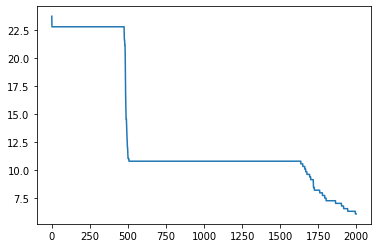

In [51]:
plt.plot(list(range(len(model.log_loss_hist))), model.log_loss_hist)
plt.show()

## Validation process

validate the Neural Network working with test data

In [52]:
# Make the prediction on test data and measure performance
y_pred = model.predict(x_test)

y_test_out = np.argmax(y_test, axis=1)
y_pred_out = np.argmax(y_pred, axis=0)

print(f"Accuracy Score: {np.round(accuracy_score(y_test_out, y_pred_out)*100,2)}")

Accuracy Score: 80.95


In [53]:
# print some data test
for i in range(10):
    print(f"predict: {y_pred_out[i]}, target: {y_test_out[i]}")

predict: 2, target: 2
predict: 1, target: 0
predict: 2, target: 2
predict: 0, target: 0
predict: 1, target: 0
predict: 0, target: 0
predict: 1, target: 1
predict: 1, target: 1
predict: 1, target: 1
predict: 1, target: 1
